# Preparation

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
from matplotlib.ticker import FormatStrFormatter
import itertools as it
from copy import deepcopy

In [2]:
#from google.colab import drive

connect_to_drive = False

if connect_to_drive:
  drive.mount('/content/drive', force_remount=True)
  os.chdir('/content/drive/Shared drives/Calugaru - RecSys SVD/ntb')
  !pwd

### Exp

In [3]:
def flatten_dict(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def read_json(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

In [4]:
def load_all_configurations(exp_name:str='8dec_amz', folder_name:str= '../out/exp/'):
    experiments = {}
    for single_config in os.listdir(os.path.join(os.getcwd(),folder_name,exp_name)):
        exp_id = single_config.replace('.json', '')
        data = read_json(os.path.join(os.getcwd(),folder_name,exp_name,single_config))
        experiments[exp_id] = flatten_dict(data)
    return pd.DataFrame.from_dict(dict(sorted(experiments.items())), "index") #sorted is not actually needed

In [5]:
def load_metrics(exp_name:str='8dec_amz', folder_name:str= '../out/log/'):
    results = {}
    exp_log_folder = os.path.join(os.getcwd(),folder_name,exp_name)
    for exp_id in os.listdir(exp_log_folder):
        metrics_filepath = os.path.join(exp_log_folder,exp_id,'lightning_logs/version_0/metrics.csv')
        data = pd.read_csv(metrics_filepath)
        results[exp_id] = data
    return dict(sorted(results.items()))

In [6]:
def get_metrics_given_best_val(metrics_per_epoch, metrics_names, metrics_prefix = "val", metrics_dataloader_idx=1, val_prefix = "val", val_metric="NDCG@10", val_dataloader_idx=0, fix_rec_at_k=False):
    if fix_rec_at_k:
        val_metric =val_metric.replace('@','_@')
        metrics_names = [metric.replace('@','_@') for metric in metrics_names]
    val_key = f"{val_prefix}_{val_metric}"
    if val_dataloader_idx is not None:
        val_key += f"/dataloader_idx_{val_dataloader_idx}"
    metric_keys = [f"{metrics_prefix}_{metric}" for metric in metrics_names]
    if metrics_dataloader_idx is not None:
        metric_keys = [f"{metric}/dataloader_idx_{metrics_dataloader_idx}" for metric in metric_keys]
    best_metrics = {}
    for exp_id, metrics in metrics_per_epoch.items():
        best_val_row = metrics[val_key].argmax()
        best_metrics[exp_id] = {metric_name: metrics[metric_key][best_val_row] for metric_name, metric_key in zip(metrics_names,metric_keys)}
    return pd.DataFrame.from_dict(dict(sorted(best_metrics.items())), "index") #sorted is not actually needed

In [7]:
def hotfix_table(table, col, value=0.5):
    for exp_id in table.index.get_level_values(0).unique():
        exp_loc = table.index.get_level_values(0) == exp_id
        vals = table.loc[exp_loc][col][1:-1].values
        mean_vals = (table.loc[exp_loc][col][:-2].values+table.loc[exp_loc][col][2:].values)/2
        over_threshold = np.abs(vals-mean_vals)>value
        sel_app = exp_loc
        app = np.concatenate((np.array([False]),over_threshold,np.array([False])))
        sel_app[sel_app] = app
        table.loc[sel_app,col] = mean_vals[over_threshold]
    return table

In [8]:
columns_for_diffs = ['duration', 'emissions', 'emissions_rate', 'cpu_power', 'gpu_power',
                    'ram_power', 'cpu_energy', 'gpu_energy', 'ram_energy',
                    'energy_consumed']
columns_that_are_same = ['project_name', 'run_id', 'country_name',
    'country_iso_code', 'region', 'cloud_provider', 'cloud_region', 'os',
    'python_version', 'codecarbon_version', 'cpu_count', 'cpu_model',
    'gpu_count', 'gpu_model', 'longitude', 'latitude', 'ram_total_size',
    'tracking_mode', 'on_cloud', 'pue']
columns_that_are_different = ['timestamp']

def load_emissions(exp_name:str='8dec_amz', folder_name:str= '../out/log/'):
    emissions = {}
    exp_log_folder = os.path.join(os.getcwd(),folder_name,exp_name)
    for exp_id in os.listdir(exp_log_folder):
        emissions_filepath = os.path.join(exp_log_folder,exp_id,'emissions.csv')
        if not os.path.exists(emissions_filepath): continue
        data = pd.read_csv(emissions_filepath)

        new_data = {}
        for column in columns_for_diffs:
            #TODO: generalize to more splits / rows of emissions
            new_data[f"train_{column}"] = data.iloc[0][column]
            new_data[f"test_{column}"] = data.iloc[1][column] - data.iloc[0][column]
        for column in columns_that_are_same:
            new_data[f"{column}"] = data.iloc[0][column]
        for column in columns_that_are_different:
            new_data[f"train_{column}"] = data.iloc[0][column]
            new_data[f"test_{column}"] = data.iloc[1][column]
        emissions[exp_id] = new_data

    return pd.DataFrame.from_dict(dict(sorted(emissions.items())), "index") #sorted is not actually needed

In [9]:
modifiers = {"":1, "K":1e3, "M":1e6, "G":1e9, "T":1e12, "P":1e15}
strings_to_search = {"num_params":"params per GPU:",
                     "flops": "fwd flops per GPU:",
                     "latency": "fwd latency:",
                     "FLOPS": "fwd FLOPS per GPU = fwd flops per GPU / fwd latency:"}

def extract_flops_info(complete_string, string_to_search):
    if string_to_search in complete_string:
        value = complete_string.split(string_to_search)[1].split("\n")[0].strip()
    else: value = "nan"
    measure = ""
    if " " in value: value, measure = value.split(" ")
    scale = measure[0] if len(measure)>0 else ""
    if scale not in modifiers:
        scale = ""
        measure = " " + measure
    unit = "" if len(measure)==1 else measure[1:]
    return float(value)*modifiers[scale], unit

def load_flops(exp_name:str='8dec_amz', folder_name:str= '../out/log/', split_keys = ["train", "test"]):
    flops = {}
    exp_log_folder = os.path.join(os.getcwd(),folder_name,exp_name)
    for exp_id in os.listdir(exp_log_folder):
        new_data = {}
        for split_key in split_keys:
            flops_filepath = os.path.join(exp_log_folder,exp_id,f'{split_key}_flops.txt')
            if not os.path.exists(flops_filepath): continue
            #load flops_filepath txt
            with open(flops_filepath, 'r') as file:
                data = file.read()

            for measure_name,string_to_search in strings_to_search.items():
                value, unit = extract_flops_info(data, string_to_search)
                measure_key = f"{split_key}_{measure_name}"
                #if unit != "": measure_key += f" ({unit})"
                new_data[measure_key] = value

        flops[exp_id] = new_data

    return pd.DataFrame.from_dict(dict(sorted(flops.items())), "index") #sorted is not actually needed

In [10]:
## Add emissions and flops info to metrics_per_epoch
def add_info_single_df(df, exp_data, subset_col, split_name, column_labels):
    if subset_col not in df.columns:
        split_subset = np.zeros(len(df), dtype=bool)
        split_subset[-1] = True
    else:
        split_subset = ~df[subset_col].isna()
    num_split = sum(split_subset)
    for label in column_labels:
        split_label = f"{split_name}_{label}"
        df.loc[split_subset,split_label] = np.linspace(exp_data[split_label]/num_split,exp_data[split_label],num_split)


def add_info_to_metrics_per_epoch(metrics_per_epoch, complete_data, column_labels, split_names = ["train", "test"], repeat_for = ["val_loss/dataloader_idx_0",None]):
    for exp_id,df in metrics_per_epoch.items():
        for split_name,repeat_col in zip(split_names,repeat_for):
            add_info_single_df(df, complete_data.loc[exp_id], f"{split_name}_loss", split_name, column_labels)
            if repeat_col is not None:
                add_info_single_df(df, complete_data.loc[exp_id], repeat_col, split_name, column_labels)
        metrics_per_epoch[exp_id] = df

### Table utils

In [11]:
def subset_data(complete_data, subset_selection={}, subset_keep=[], merge_columns={}):
    subset_data = complete_data
    for label, value in subset_selection.items():
        subset_data = subset_data[subset_data[label] == value]

    for condition1, condition2 in subset_keep:
        for label, value in condition1.items():
            subset_data2 = subset_data[subset_data[label] == value]
        indices = subset_data2.index
        for label, value in condition2.items():
            subset_data2 = subset_data2[subset_data2[label] == value]
        indices2 = subset_data2.index
        #remove for subset_data idx not in indices2
        indices_to_remove = [idx for idx in indices if idx not in indices2]
        subset_data = subset_data.drop(indices_to_remove)

    for col_name, cols in merge_columns.items():
        subset_data[col_name] = subset_data.loc[:,cols].apply(lambda row: '_'.join([str(x) for x in row if pd.notnull(x)]), axis=1)
        subset_data = subset_data.drop(columns=cols)

    return subset_data

def generate_table(subset_data,
                   label_convert_dict,
                   rows_labels, column_labels,
                   pivot_agg = lambda x: x,
                   table_name="results", save_table=False, round_at=4,
                   exp_name:str='8dec_amz', folder_name:str= '../out/results/',):

    subset_data = subset_data[rows_labels + column_labels]


    table = pd.pivot_table(subset_data, index=rows_labels, values=column_labels, dropna=False, aggfunc=pivot_agg)

    # Drop if all column_labels are nans
    drop_row = table[column_labels].isnull().all(axis=1)
    table = table[~drop_row]

    table.reset_index(inplace=True)

    table = table.round(round_at)

    table['svd_type'] = table['svd_type'].map(label_convert_dict)

    if save_table:
        results_path = os.path.join(folder_name,exp_name)
        if not os.path.exists(results_path):
            os.makedirs(results_path)
        table.to_csv(os.path.join(results_path,f'{table_name}.csv'), index=False)
    return table

### Plot utils

In [12]:
def to_color_blind(color):
    if color == 'red':
        return '#e41a1c'
    elif color == 'blue':
        return '#377eb8'
    elif color == 'orange':
        return '#ff7f00'
    elif color == 'green':
        return '#4daf4a'
    elif color == 'brown':
        return '#a65628'
    elif color == 'grey':
        return '#999999'
    elif color == 'yellow':
        return '#dede00'
    elif color == 'pink':
        return '#f781bf'
    elif color == 'purple':
        return '#984ea3'
    else:
        raise NotImplementedError("color not available")

def obtain_markers(number_of_markers):
    list_of_markers = ['o', 'v', 's', 'p', 'P', '*', 'X', '+', 'D', 'x']
    return list_of_markers[:number_of_markers]

def obtain_color(number_of_colors):
    all = ['#e41a1c', '#377eb8','#ff7f00','#4daf4a','#a65628',
        '#999999','#dede00','#f781bf','#984ea3']
    return all[:number_of_colors]

In [13]:
def create_plot(plot_instructions,
                **kwargs):
    final_fig, final_ax = plt.subplots(**plot_instructions["subplots"])

    # If final_ax is iterable
    if hasattr(final_ax, '__iter__'):
        for i,ax in enumerate(final_ax.flatten()):
            single_plot(ax, **{k:v[i] if isinstance(v, list) or isinstance(v, tuple) else v for k,v in kwargs.items()})
    else:
        single_plot(final_ax, **kwargs)

    for plt_func, plt_kwargs in plot_instructions.items():
        if plt_func != "subplots":
            run_plot_func(plt, plt_func, plt_kwargs)

def single_plot(ax,
                data,
                label_columns: list,
                x_column: str,
                y_column: str,
                plot_type = "plot",
                plot_kwargs = {},
                ax_instructions: dict = {},
                label_convert_dict: dict = {}):
    labels = []
    for col in label_columns:
        labels.append(data[col].unique())
    labels = list(it.product(*labels))
    plot_labels = [x[0] if len(x) == 1 else x for x in labels]
    plot_labels = [label_convert_dict.get(x, x) for x in plot_labels]
    labels = [x[1] for x in sorted(zip(plot_labels,labels))]
    plot_labels = sorted(plot_labels)

    colors = obtain_color(len(labels))
    markers = obtain_markers(len(labels))

    for i, values in enumerate(labels):
        subset_data = data
        for col, value in zip(label_columns, values):
            subset_data = subset_data[subset_data[col] == value]

        x_values = subset_data[x_column]
        y_values = subset_data[y_column]
        getattr(ax,plot_type)(x_values, y_values, label=plot_labels[i], color=colors[i], marker=markers[i], **plot_kwargs)

    for ax_func, ax_kwargs in ax_instructions.items():
        run_plot_func(ax, ax_func, ax_kwargs.copy())

def run_plot_func(obj, func, kwargs):
    other_func_instructions = None
    if "__kwargs__" in kwargs:
        func_kwargs = kwargs.pop("__kwargs__")
        kwargs, other_func_instructions = func_kwargs, kwargs

    app = getattr(obj, func)(**kwargs)
    if other_func_instructions is not None:
        for func, kwargs in other_func_instructions.items():
            run_plot_func(app, func, kwargs)

    # for index, (model, data) in enumerate(results.items()):
    #     ablation_values = list(data.keys())
    #     y_values = list(data.values())
    #     plt.plot(ablation_values, y_values, label=model, color=colors[index], marker=markers[index])
    #
    # plt.xticks(ablation_values, ablation_values)
    # plt.xlabel(names_to_labels[ablation_type])
    # plt.ylabel(metric)
    # plt.title(names_to_labels[dataset_name])
    # plt.legend()
    # plt.show()

In [14]:
def merge_epoch_data(metrics_per_epoch, table, table_columns = [], epoch_column_not_na = "val_loss/dataloader_idx_1"):
    subset_metrics = {}
    for exp_id in table.index:
        subset_metrics[exp_id] = metrics_per_epoch[exp_id]

        subset_metrics[exp_id] = subset_metrics[exp_id].loc[~subset_metrics[exp_id][epoch_column_not_na].isna()]

        for col in table_columns:
            subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]

    #concat all dataframes by row
    subset_metrics = pd.concat(subset_metrics)

    return subset_metrics

### Important vars

In [15]:
names_to_labels = {'ml-1m' : 'MovieLens 1M', 'ml-100k' : 'MovieLens 100k', 'amazon_beauty' : 'Amazon Beauty', 'foursquare-tky' : 'Foursquare TKY', 'foursquare-nyc' : 'Foursquare NYC',
                   'emb_size' : 'Embedding Size', 'lookback' : 'Input sequence length', 'carbon_emissions' : r'CO\textsubscript{2}-eq', 'model_size' : 'Model Size',
                   'ml-20m': 'MovieLens 20M'}

In [16]:
all_datasets = sorted(['ml-1m', 'ml-100k', 'amazon_beauty', 'foursquare-tky', 'foursquare-nyc'])
all_models= sorted(['SASRec','NARM', 'GRU4Rec', 'BERT4Rec', 'CORE'])
metrics_names = ["Precision", "Recall", "NDCG", "MAP","MRR", "F1"]
metrics_ks = [5, 10, 20]
all_metrics_names = [f"{metric}@{k}" for metric in metrics_names for k in metrics_ks]

# MAIN

## Load all experiments

### Exp configs

In [18]:
exp_name = "new_gru_ml1m"

In [19]:
all_exps = load_all_configurations(exp_name)

In [20]:
all_exps

,data_params.collator_params.lookback,data_params.collator_params.lookforward,data_params.collator_params.num_items,data_params.collator_params.num_negatives.test,data_params.collator_params.num_negatives.train,data_params.collator_params.num_negatives.val,data_params.collator_params.out_seq_len.test,data_params.collator_params.out_seq_len.train,data_params.collator_params.out_seq_len.val,data_params.collator_params.padding_value,...,model.trainer_params.max_epochs,model.useSVD,svd.svd.cutoff,svd.svd.freeze_emb,svd.svd.mean_imputation,svd.svd.use_diag,model.freeze_emb,model.mean_imputation,model.svd_cutoff,model.use_diag
HPqLA22KaxBrgNj9,200,1,3416,100,1,1,1,None,1,0,...,500,False,True,False,both,False,NaN,NaN,NaN,NaN
T9G8zHpKO4KzVzku,200,1,3416,100,1,1,1,None,1,0,...,500,False,True,False,both,False,NaN,NaN,NaN,NaN
TAJK7gusZOezId0r,200,1,3416,100,1,1,1,None,1,0,...,500,True,True,False,both,False,False,both,59.0,False
Y2fIEz0fbbVKraHU,200,1,3416,100,1,1,1,None,1,0,...,500,True,True,False,both,False,False,both,59.0,False
YMzcYTfpY4Ik09Nr,200,1,3416,100,1,1,1,None,1,0,...,500,True,True,False,both,False,False,both,59.0,False
cQJTXYrltVtSeim1,200,1,3416,100,1,1,1,None,1,0,...,500,False,True,False,both,False,NaN,NaN,NaN,NaN


### Load exp metrics

In [21]:
metrics_per_epoch = load_metrics(exp_name)
metrics_per_epoch

{'HPqLA22KaxBrgNj9':       epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  test_MAP_@10  \
 0         0     47          NaN          NaN         NaN           NaN   
 1         0     47          NaN          NaN         NaN           NaN   
 2         1     95          NaN          NaN         NaN           NaN   
 3         1     95          NaN          NaN         NaN           NaN   
 4         2    143          NaN          NaN         NaN           NaN   
 ...     ...    ...          ...          ...         ...           ...   
 996     498  23951          NaN          NaN         NaN           NaN   
 997     498  23951          NaN          NaN         NaN           NaN   
 998     499  23999          NaN          NaN         NaN           NaN   
 999     499  23999          NaN          NaN         NaN           NaN   
 1000    500  24000     0.145577     0.083852    0.230785      0.159379   
 
       test_MAP_@20  test_MAP_@5  test_MRR_@10  test_MRR_@20  ...  \
 0       

In [22]:
best_metrics = get_metrics_given_best_val(metrics_per_epoch, all_metrics_names, fix_rec_at_k=True)
best_metrics

,Precision_@5,Precision_@10,Precision_@20,Recall_@5,Recall_@10,Recall_@20,NDCG_@5,NDCG_@10,NDCG_@20,MAP_@5,MAP_@10,MAP_@20,MRR_@5,MRR_@10,MRR_@20,F1_@5,F1_@10,F1_@20
HPqLA22KaxBrgNj9,0.136722,0.079073,0.044065,0.683609,0.790728,0.881291,0.532076,0.566772,0.589635,0.220998,0.158860,0.107521,0.481636,0.495984,0.502245,0.224491,0.142387,0.083045
T9G8zHpKO4KzVzku,0.137682,0.079636,0.043808,0.688411,0.796358,0.876159,0.536656,0.571749,0.592024,0.223458,0.160527,0.108424,0.485996,0.500590,0.506209,0.220504,0.140872,0.082579
TAJK7gusZOezId0r,0.136490,0.079503,0.044040,0.682450,0.795033,0.880795,0.533149,0.569641,0.591526,0.222105,0.159575,0.108077,0.483344,0.498452,0.504565,0.215035,0.138991,0.082208
Y2fIEz0fbbVKraHU,0.136788,0.078957,0.044089,0.683940,0.789570,0.881788,0.530980,0.565311,0.588672,0.220462,0.158637,0.107453,0.480003,0.494276,0.500710,0.218640,0.139916,0.082449
YMzcYTfpY4Ik09Nr,0.136987,0.079387,0.043949,0.684934,0.793874,0.878973,0.532421,0.567876,0.589583,0.221131,0.159217,0.107840,0.481611,0.496375,0.502434,0.217220,0.139887,0.082456
cQJTXYrltVtSeim1,0.137517,0.079371,0.043882,0.687583,0.793709,0.877649,0.535064,0.569428,0.590684,0.222020,0.159573,0.107898,0.484368,0.498577,0.504429,0.217422,0.139663,0.082298


In [23]:
emissions = load_emissions(exp_name)
emissions

""


In [75]:
#all_flops = load_flops(exp_name)
#all_flops

In [24]:
#complete_data = all_exps.join([best_metrics, emissions], how='inner') #all_flops
complete_data = all_exps.join([best_metrics], how='inner')
#join[all_exps, best_metrics, emissions, all_flops], axis=1)
metrics_per_epoch = {exp_id: metrics_per_epoch[exp_id] for exp_id in complete_data.index}
complete_data

,data_params.collator_params.lookback,data_params.collator_params.lookforward,data_params.collator_params.num_items,data_params.collator_params.num_negatives.test,data_params.collator_params.num_negatives.train,data_params.collator_params.num_negatives.val,data_params.collator_params.out_seq_len.test,data_params.collator_params.out_seq_len.train,data_params.collator_params.out_seq_len.val,data_params.collator_params.padding_value,...,NDCG_@20,MAP_@5,MAP_@10,MAP_@20,MRR_@5,MRR_@10,MRR_@20,F1_@5,F1_@10,F1_@20
HPqLA22KaxBrgNj9,200,1,3416,100,1,1,1,None,1,0,...,0.589635,0.220998,0.158860,0.107521,0.481636,0.495984,0.502245,0.224491,0.142387,0.083045
T9G8zHpKO4KzVzku,200,1,3416,100,1,1,1,None,1,0,...,0.592024,0.223458,0.160527,0.108424,0.485996,0.500590,0.506209,0.220504,0.140872,0.082579
TAJK7gusZOezId0r,200,1,3416,100,1,1,1,None,1,0,...,0.591526,0.222105,0.159575,0.108077,0.483344,0.498452,0.504565,0.215035,0.138991,0.082208
Y2fIEz0fbbVKraHU,200,1,3416,100,1,1,1,None,1,0,...,0.588672,0.220462,0.158637,0.107453,0.480003,0.494276,0.500710,0.218640,0.139916,0.082449
YMzcYTfpY4Ik09Nr,200,1,3416,100,1,1,1,None,1,0,...,0.589583,0.221131,0.159217,0.107840,0.481611,0.496375,0.502434,0.217220,0.139887,0.082456
cQJTXYrltVtSeim1,200,1,3416,100,1,1,1,None,1,0,...,0.590684,0.222020,0.159573,0.107898,0.484368,0.498577,0.504429,0.217422,0.139663,0.082298


In [25]:
column_labels = ['duration', 'emissions', 'emissions_rate', 'cpu_power','gpu_power', 'ram_power', 'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed'] #, 'flops', 'latency', 'FLOPS']
#add_info_to_metrics_per_epoch(metrics_per_epoch, complete_data, column_labels)
metrics_per_epoch

{'HPqLA22KaxBrgNj9':       epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  test_MAP_@10  \
 0         0     47          NaN          NaN         NaN           NaN   
 1         0     47          NaN          NaN         NaN           NaN   
 2         1     95          NaN          NaN         NaN           NaN   
 3         1     95          NaN          NaN         NaN           NaN   
 4         2    143          NaN          NaN         NaN           NaN   
 ...     ...    ...          ...          ...         ...           ...   
 996     498  23951          NaN          NaN         NaN           NaN   
 997     498  23951          NaN          NaN         NaN           NaN   
 998     499  23999          NaN          NaN         NaN           NaN   
 999     499  23999          NaN          NaN         NaN           NaN   
 1000    500  24000     0.145577     0.083852    0.230785      0.159379   
 
       test_MAP_@20  test_MAP_@5  test_MRR_@10  test_MRR_@20  ...  \
 0       

## Table generation

In [130]:
#for col in sorted(complete_data.columns): print(col)

In [26]:
rows_labels = ["svd_type"] #"data_params.name","model.rec_model.name",  "model.trainer_params.max_epochs"
#metrics_names = ["Precision", "Recall", "NDCG", "MRR", "MAP", "F1"]
metrics_names = ["Precision", "Recall", "NDCG","MRR"]
metrics_ks = [5, 10, 20]
column_labels = sorted([f"{metric}_@{k}" for metric in metrics_names for k in metrics_ks])
subset_selection = {}
subset_keep = []



merge_columns = {"svd_type": ["model.useSVD","model.use_diag", "model.mean_imputation", "model.svd_cutoff"]}
#label_convert_dict = {"False_NaN_NaN": "No SVD",
 #                     "True_False_both": "global mean SVD",
  #                    "True_True_both": "global mean SVD diag"}



label_convert_dict = {"False_False_NaN_NaN": "No SVD",
                    "True_False_user_item_mean": "user-item mean",
                    "True_True_user_item_mean": "user-item mean DIAG",
                     "True_True_both": "global mean DIAG", 
                     "True_False_both": "global mean", 
                     "True_False_center_both": "global centering", 
                     "True_True_center_both": "global_centering DIAG", 
                     "True_True_iterative_svd": "iterative svd 10 DIAG",
                     "True_False_iterative_svd": "iterative svd 10",
                     "True_True_iterative_svd_64": "iterative svd 64 DIAG",
                     "True_False_iterative_svd_64": "iterative svd 64",
                     "True_False_iterative_svd_accurate": "iterative svd accurate",
                     "True_False_both_3.0": "global mean cutoff 3",
                     "True_True_both_3.0": "global mean DIAG cutoff 3",
                     "True_False_both_64.0": "global mean cutoff 64",
                     "True_True_both_64.0": "global mean DIAG cutoff 64",
                     "True_False_both_128.0": "global mean cutoff 128",
                     "True_True_both_128.0": "global mean DIAG cutoff 128",
                     "True_False_both_22.0": "global mean cutoff 22",
                     "True_True_both_22.0": "global mean DIAG cutoff 22",
                     "True_False_both_59.0": "global mean cutoff 59",
                     "True_False_both_48.0": "global mean cutoff 48"
                     }

                      
#merge_columns = {"svd_type": ["model.useSVD","model.freeze_emb","model.use_diag","model.svd_cutoff"]}
#label_convert_dict = {"False": "No SVD", "True_False_False": "SVD", "True_False_True": "SVD diag", "True_True_False": "SVD freeze","True_True_True": "SVD freeze diag", "True_False_False_64.0": "SVD + cutoff", "True_False_True_64.0": "SVD diag + cutoff"}
#label_convert_dict = {"False_False": "No SVD", "True_False_False": "SVD", "True_True": "SVD freeze", "True_False_64.0":"SVD + cutoff", "True_True_64.0":"SVD freeze+cutoff"}


In [27]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), label_convert_dict, rows_labels, column_labels, exp_name = "8dec_amz", save_table=True) #, pivot_agg=list)

#table

ValueError: Must produce aggregated value

In [28]:
# # To check which rows are duplicated
# df = complete_data.loc[(complete_data["model.rec_model.name"]=="SASRec") & (complete_data["data_params.name"]=="ml-1m")]
# #Find columns in df with different values
# columns_with_different_values = []
# for column in df.columns:
#     if len(df[column].apply(lambda x: str(x)).unique()) > 1:
#         columns_with_different_values.append(column)
# print(columns_with_different_values)
# complete_data.loc[(complete_data["model.rec_model.name"]=="SASRec") & (complete_data["data_params.name"]=="ml-1m")][columns_with_different_values]

## Plot

In [28]:
main_rows_labels = ["svd_type"]
metrics_names = ["Precision", "Recall", "NDCG", "MRR"]
metrics_ks = [5, 10, 20]
column_labels = sorted([f"{metric}_@{k}" for metric in metrics_names for k in metrics_ks])
subset_keep = []


#merge_columns = {"svd_type": ["model.useSVD","model.freeze_emb","model.use_diag","model.svd_cutoff"]}
#label_convert_dict = {"False": "No SVD", "True_False_False": "SVD", "True_False_True": "SVD diag", "True_True_False": "SVD freeze","True_True_True": "SVD freeze diag", "True_False_False_64.0": "SVD + cutoff", "True_False_True_64.0": "SVD diag + cutoff"}

merge_columns={}


### Embedding size

In [29]:
main_x_column = "model.rec_model.emb_size"
main_x_label = "Embedding Size"
super_plot_name = "emb_size_NDCG@10"
super_title = "Performance with varying embedding size"

In [31]:
rows_label_to_add = [main_x_column]
rows_labels = main_rows_labels + rows_label_to_add

subset_selection = {"model.rec_model.emb_size":64}

In [32]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), label_convert_dict, rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

,svd_type,model.rec_model.emb_size,MRR_@10,MRR_@20,MRR_@5,NDCG_@10,NDCG_@20,NDCG_@5,Precision_@10,Precision_@20,Precision_@5,Recall_@10,Recall_@20,Recall_@5
0,NaN,64,0.5006,0.5062,0.4860,0.5717,0.5920,0.5367,0.0796,0.0438,0.1377,0.7964,0.8762,0.6884
1,global mean cutoff 59,64,0.4964,0.5024,0.4816,0.5679,0.5896,0.5324,0.0794,0.0439,0.1370,0.7939,0.8790,0.6849


In [33]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "set_xlim": {"left": 4},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

In [34]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name#+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

merge_columns = {"svd_type": ["model.useSVD","model.use_diag", "model.mean_imputation","model.svd_cutoff"]}
label_convert_dict = {"False_False_NaN_NaN": "No SVD",
                    "True_False_user_item_mean": "user-item mean",
                    "True_True_user_item_mean": "user-item mean DIAG",
                     "True_True_both": "global mean DIAG", 
                     "True_False_both": "global mean", 
                     "True_False_center_both": "global centering", 
                     "True_True_center_both": "global_centering DIAG", 
                     "True_True_iterative_svd": "iterative svd 10 DIAG",
                     "True_False_iterative_svd": "iterative svd 10",
                     "True_True_iterative_svd_64": "iterative svd 64 DIAG",
                     "True_False_iterative_svd_64": "iterative svd 64",
                     "True_False_iterative_svd_accurate": "iterative svd accurate",
                     "True_False_both_3.0": "global mean cutoff 3",
                     "True_True_both_3.0": "global mean DIAG cutoff 3",
                     "True_False_both_64.0": "global mean cutoff 64",
                     "True_True_both_64.0": "global mean DIAG cutoff 64",
                     "True_False_both_128.0": "global mean cutoff 128",
                     "True_True_both_128.0": "global mean DIAG cutoff 128",
                     "True_False_both_22.0": "global mean cutoff 22",
                     "True_True_both_22.0": "global mean DIAG cutoff 22",
                     "True_False_both_59.0": "global mean cutoff 59",
                     "True_False_both_48.0": "global mean cutoff 48"
                     }


#label_convert_dict = {"False_False": "No SVD", "True_False": "SVD", "True_True": "SVD + freeze"}
#label_convert_dict = {"False": "No SVD", "True_False": "SVD", "True_True": "SVD freeze", "True_False_64.0":"SVD + cutoff", "True_True_64.0":"SVD freeze+cutoff"}
#label_convert_dict = {"False": "No SVD", "True_False_False": "SVD", "True_False_True": "SVD diag", "True_True_False": "SVD freeze","True_True_True": "SVD freeze diag", "True_False_False_64.0": "SVD + cutoff", "True_False_True_64.0": "SVD diag + cutoff"}


#create_plot(plot_instructions, data=table, label_columns=["svd_type"], x_column=x_column, y_column=y_column,
 #         ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

In [35]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "MRR@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

### Emb size = 64

In [36]:
#complete_data = complete_data[complete_data['model.freeze_emb'] != True]
#complete_data = complete_data[complete_data['model.use_diag'] != True]
#complete_data = complete_data[complete_data['model.svd_cutoff'] != 64.0]
#complete_data = complete_data[complete_data['model.svd_cutoff'] != 128.0]
#complete_data = complete_data[complete_data['model.svd_cutoff'] != 3.0]
#complete_data = complete_data[complete_data['model.svd_cutoff'] != None]
complete_data

,data_params.collator_params.lookback,data_params.collator_params.lookforward,data_params.collator_params.num_items,data_params.collator_params.num_negatives.test,data_params.collator_params.num_negatives.train,data_params.collator_params.num_negatives.val,data_params.collator_params.out_seq_len.test,data_params.collator_params.out_seq_len.train,data_params.collator_params.out_seq_len.val,data_params.collator_params.padding_value,...,MAP_@5,MAP_@10,MAP_@20,MRR_@5,MRR_@10,MRR_@20,F1_@5,F1_@10,F1_@20,svd_type
HPqLA22KaxBrgNj9,200,1,3416,100,1,1,1,None,1,0,...,0.220998,0.158860,0.107521,0.481636,0.495984,0.502245,0.224491,0.142387,0.083045,False
T9G8zHpKO4KzVzku,200,1,3416,100,1,1,1,None,1,0,...,0.223458,0.160527,0.108424,0.485996,0.500590,0.506209,0.220504,0.140872,0.082579,False
TAJK7gusZOezId0r,200,1,3416,100,1,1,1,None,1,0,...,0.222105,0.159575,0.108077,0.483344,0.498452,0.504565,0.215035,0.138991,0.082208,True_False_both_59.0
Y2fIEz0fbbVKraHU,200,1,3416,100,1,1,1,None,1,0,...,0.220462,0.158637,0.107453,0.480003,0.494276,0.500710,0.218640,0.139916,0.082449,True_False_both_59.0
YMzcYTfpY4Ik09Nr,200,1,3416,100,1,1,1,None,1,0,...,0.221131,0.159217,0.107840,0.481611,0.496375,0.502434,0.217220,0.139887,0.082456,True_False_both_59.0
cQJTXYrltVtSeim1,200,1,3416,100,1,1,1,None,1,0,...,0.222020,0.159573,0.107898,0.484368,0.498577,0.504429,0.217422,0.139663,0.082298,False


In [37]:
subset_selection = {"model.rec_model.emb_size":64}

In [38]:
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
#sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

/tmp/ipykernel_1837680/1574984640.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data[col_name] = subset_data.loc[:,cols].apply(lambda row: '_'.join([str(x) for x in row if pd.notnull(x)]), axis=1)
/tmp/ipykernel_1837680/3120208689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_metrics[exp_id].loc[:,col] = table.loc[exp_id,col]
/tmp/ipykernel_1837680/3120208689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

epoch   step  test_F1_@10  test_F1_@20  test_F1_@5  \
T9G8zHpKO4KzVzku 0        0     47          NaN          NaN         NaN   
                 2        1     95          NaN          NaN         NaN   
                 4        2    143          NaN          NaN         NaN   
                 6        3    191          NaN          NaN         NaN   
                 8        4    239          NaN          NaN         NaN   
...                     ...    ...          ...          ...         ...   
YMzcYTfpY4Ik09Nr 990    495  23807          NaN          NaN         NaN   
                 992    496  23855          NaN          NaN         NaN   
                 994    497  23903          NaN          NaN         NaN   
                 996    498  23951          NaN          NaN         NaN   
                 998    499  23999          NaN          NaN         NaN   

                      test_MAP_@10  test_MAP_@20  test_MAP_@5  test_MRR_@10  \
T9G8zHpKO4KzVzku 0             NaN           NaN          NaN           NaN   
                 2             NaN           NaN          NaN           NaN   
                 4             NaN           NaN          NaN           NaN   
                 6             NaN           NaN          NaN           NaN   
                 8             NaN           NaN          NaN           NaN   
...                            ...           ...          ...           ...   
YMzcYTfpY4Ik09Nr 990           NaN           NaN          NaN           NaN   
                 992           NaN           NaN          NaN           NaN   
                 994           NaN           NaN          NaN           NaN   
                 996           NaN           NaN          NaN           NaN   
                 998           NaN           NaN          NaN           NaN   

                      test_MRR_@20  ...  val_Recall_@10/dataloader_idx_0  \
T9G8zHpKO4KzVzku 0             NaN  ...                              1.0   
                 2             NaN  ...                              1.0   
                 4             NaN  ...                              1.0   
                 6             NaN  ...                              1.0   
                 8             NaN  ...                              1.0   
...                            ...  ...                              ...   
YMzcYTfpY4Ik09Nr 990           NaN  ...                              1.0   
                 992           NaN  ...                              1.0   
                 994           NaN  ...                              1.0   
                 996           NaN  ...                              1.0   
                 998           NaN  ...                              1.0   

                      val_Recall_@10/dataloader_idx_1  \
T9G8zHpKO4KzVzku 0                           0.421192   
                 2                           0.431954   
                 4                           0.435927   
                 6                           0.446192   
                 8                           0.473675   
...                                               ...   
YMzcYTfpY4Ik09Nr 990                         0.792219   
                 992                         0.792715   
                 994                         0.788742   
                 996                         0.790397   
                 998                         0.794205   

                      val_Recall_@20/dataloader_idx_0  \
T9G8zHpKO4KzVzku 0                                1.0   
                 2                                1.0   
                 4                                1.0   
                 6                                1.0   
                 8                                1.0   
...                                               ...   
YMzcYTfpY4Ik09Nr 990                              1.0   
                 992                              1.0   
                 994                             

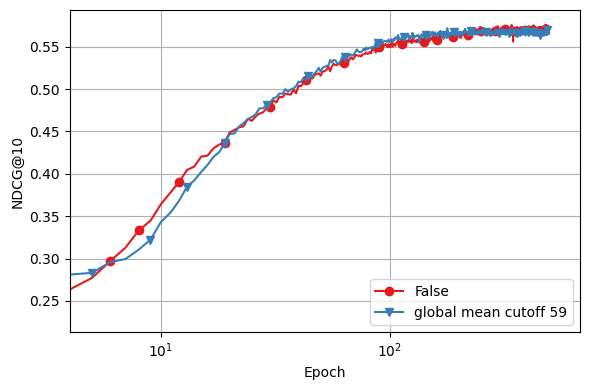

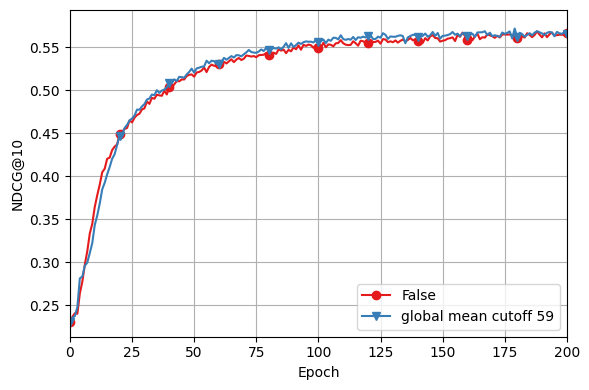

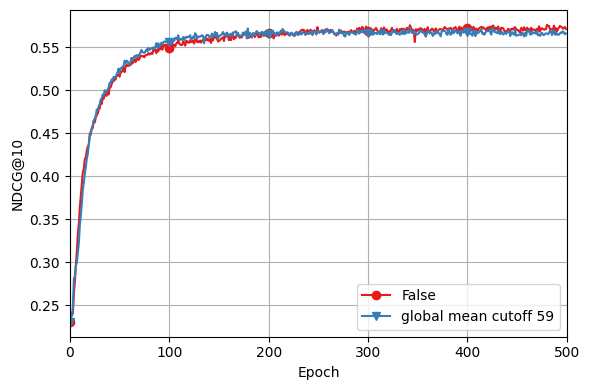

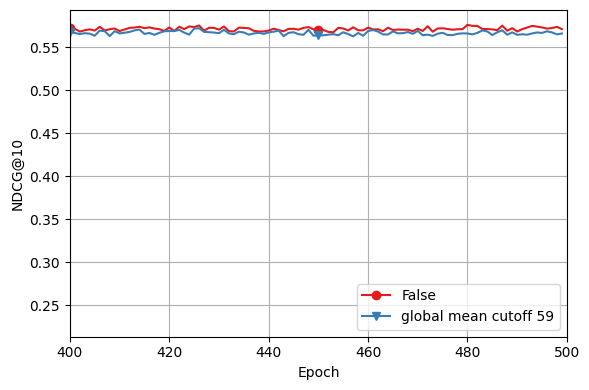

In [39]:
plot_name = "gru_ml1m_64_NDCG@10"#+super_plot_name#+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {"False_False_NaN_NaN": "No SVD",
                    "True_False_user_item_mean": "user-item mean",
                    "True_True_user_item_mean": "user-item mean DIAG",
                     "True_True_both": "global mean DIAG", 
                     "True_False_both": "global mean", 
                     "True_False_center_both": "global centering", 
                     "True_True_center_both": "global_centering DIAG", 
                     "True_True_iterative_svd": "iterative svd 10 DIAG",
                     "True_False_iterative_svd": "iterative svd 10",
                     "True_True_iterative_svd_64": "iterative svd 64 DIAG",
                     "True_False_iterative_svd_64": "iterative svd 64",
                     "True_False_iterative_svd_accurate": "iterative svd accurate",
                     "True_False_both_3.0": "global mean cutoff 3",
                     "True_True_both_3.0": "global mean DIAG cutoff 3",
                     "True_False_both_64.0": "global mean cutoff 64",
                     "True_True_both_64.0": "global mean DIAG cutoff 64",
                     "True_False_both_128.0": "global mean cutoff 128",
                     "True_True_both_128.0": "global mean DIAG cutoff 128",
                     "True_False_both_22.0": "global mean cutoff 22",
                     "True_True_both_22.0": "global mean DIAG cutoff 22",
                     "True_False_both_59.0": "global mean cutoff 59",
                     "True_False_both_48.0": "global mean cutoff 48"
                     }

repeated_ax_instructions = [ax_instructions.copy() for _ in range(4)]
#repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.525}
repeated_ax_instructions[0]["legend"] = {"loc": "lower right"}

repeated_ax_instructions[1]["set_xlim"] = {"left":0,"right":200}
#repeated_ax_instructions[1]["set_ylim"] = {"bottom":0.34,"top":0.65}
repeated_ax_instructions[1].pop("set_xscale",None)
repeated_ax_instructions[1]["legend"] = {"loc": "lower right"}

repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":500}
#repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.64,"top":0.69}
repeated_ax_instructions[2].pop("set_xscale",None)

repeated_ax_instructions[3]["set_xlim"] = {"left":400,"right":500}
#repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.64,"top":0.69}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[1]["markevery"] = 20
repeated_plot_kwargs[2]["markevery"] = 100
repeated_plot_kwargs[3]["markevery"] = 50

for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".png"
    create_plot(rep_plot_instr, data=([sas_table]*4)[i], label_columns=["svd_type"], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### FINE?

In [ ]:
y_column

#### Foursquare TKY

In [ ]:
subset_selection["data_params.name"] = "foursquare-tky"
subset_selection.pop("model.rec_model.name",None)

In [ ]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

In [ ]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

In [ ]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

In [ ]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [ ]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [ ]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

In [ ]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

In [ ]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.25}
repeated_ax_instructions[0]["legend"] = {"loc": "upper left"}
repeated_ax_instructions[1]["legend"] = {"loc": "upper left"}


repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.18,"top":0.43}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.125,"top":0.26}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.35,"top":0.77}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.45,"top":0.80}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### ML-1M

In [ ]:
subset_selection["data_params.name"] = "ml-1m"
subset_selection.pop("model.rec_model.name",None)

In [ ]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

In [ ]:
x_column = main_x_column
x_label = main_x_label
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

In [ ]:
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

In [ ]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [ ]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [ ]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

In [ ]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

In [ ]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "upper left"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.18,"top":0.41}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.05,"top":0.25}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.2,"top":0.605}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.2,"top":0.60}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

### Num negatives

In [ ]:
main_x_column = "data_params.collator_params.num_negatives.train"
main_x_label = "Number of negative items"
super_plot_name = "negatives_NDCG@10"
super_title = "Performance with varying number of negative items"

In [ ]:
rows_label_to_add = [main_x_column]
rows_labels = main_rows_labels + rows_label_to_add

subset_selection = {"data_params.collator_params.simultaneous_lookforward":1}

#### Amazon-beauty

In [ ]:
subset_selection["data_params.name"] = "amazon_beauty"
subset_selection.pop("model.rec_model.name",None)

In [ ]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

In [ ]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

In [ ]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

In [ ]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [ ]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [ ]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

In [ ]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

In [ ]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
#repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.525}

repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.28,"top":0.65}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.14,"top":0.35}
repeated_ax_instructions[3]["legend"] = {"loc": "lower left"}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.67,"top":0.695}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.6,"top":0.7}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### Foursquare TKY

In [ ]:
subset_selection["data_params.name"] = "foursquare-tky"
subset_selection.pop("model.rec_model.name",None)

In [ ]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

In [ ]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

In [ ]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "center right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

In [ ]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [ ]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [ ]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

In [ ]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

In [ ]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.25}
repeated_ax_instructions[0]["legend"] = {"loc": "upper left"}
repeated_ax_instructions[1]["legend"] = {"loc": "upper left"}


repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.16,"top":0.43}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.05,"top":0.26}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.5,"top":0.77}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.55,"top":0.82}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### ML-1M

In [ ]:
subset_selection["data_params.name"] = "ml-1m"
subset_selection.pop("model.rec_model.name",None)

In [ ]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table

In [ ]:
x_column = main_x_column
x_label = main_x_label
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

In [ ]:
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

In [ ]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [ ]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [ ]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

In [ ]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

In [ ]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "upper left"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.225,"top":0.4}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.03,"top":0.25}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.54,"top":0.605}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.4,"top":0.62}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

### Num positives/negatives

In [ ]:
main_x_column = "num_pos_neg"
main_x_label = "Number of positive/negative items"
super_plot_name = "pos_neg_NDCG@10"
super_title = "Performance with varying number of positive/negative items"

In [ ]:
rows_label_to_add = [main_x_column]
rows_labels = main_rows_labels + rows_label_to_add

subset_selection = {}
merge_columns = {"num_pos_neg":["data_params.collator_params.simultaneous_lookforward",
                                "data_params.collator_params.num_negatives.train"]}

In [ ]:
def subset_to_equal_pos_neg(table):
    def eq_pos_neg(x):
        p,n = x.split("_")
        if p==n: return True
        else: return False
    def comb_pos_neg(x):
        p,n = x.split("_")
        return int(p)
    table = table.loc[table["num_pos_neg"].apply(eq_pos_neg)]
    table["num_pos_neg"] = table["num_pos_neg"].apply(comb_pos_neg)
    # sort by number of positive items
    table = table.sort_values("num_pos_neg")
    return table

#### Amazon-beauty

In [ ]:
subset_selection["data_params.name"] = "amazon_beauty"
subset_selection.pop("model.rec_model.name",None)

In [ ]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table = subset_to_equal_pos_neg(table)
table

In [ ]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

In [ ]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

In [ ]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [ ]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [ ]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

In [ ]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

In [ ]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
#repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.525}
repeated_ax_instructions[1]["legend"] = {"loc": "upper left"}

repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.28,"top":0.65}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.17,"top":0.35}
repeated_ax_instructions[3]["legend"] = {"loc": "lower left"}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.55,"top":0.7}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[4]["legend"] = {"loc": "lower left"}
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.35,"top":0.7}
repeated_ax_instructions[5].pop("set_xscale",None)
repeated_ax_instructions[5]["legend"] = {"loc": "lower left"}


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### Foursquare TKY

In [ ]:
subset_selection["data_params.name"] = "foursquare-tky"
subset_selection.pop("model.rec_model.name",None)

In [ ]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table = subset_to_equal_pos_neg(table)
table

In [ ]:
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

In [ ]:
x_column = main_x_column
x_label = main_x_label
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

In [ ]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [ ]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [ ]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

In [ ]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

In [ ]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "lower right"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[0]["set_ylim"] = {"bottom":0.3}


repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.2,"top":0.45}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.15,"top":0.33}
repeated_ax_instructions[3].pop("set_xscale",None)
repeated_ax_instructions[3]["legend"] = {"loc": "upper left"}


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.61,"top":0.77}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.48,"top":0.8}
repeated_ax_instructions[5].pop("set_xscale",None)


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)

#### ML-1M

In [ ]:
subset_selection["data_params.name"] = "ml-1m"
subset_selection.pop("model.rec_model.name",None)

In [ ]:
table = generate_table(subset_data(complete_data, subset_selection, subset_keep, merge_columns), rows_labels, column_labels, exp_name = "april_30", save_table=True)
table = subset_to_equal_pos_neg(table)
table

In [ ]:
x_column = main_x_column
x_label = main_x_label
y_column = "NDCG_@10"
y_label = y_column.replace("_", "")

ax_instructions = {"set_xscale": {"value": "log"},
                   "set_ylabel": {"ylabel": y_label},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "size":0}},
                   "get_xaxis": {"__kwargs__":{},
                                 "set_tick_params": {"which":"minor", "width":0}},
                   "legend": {},
                   "grid":{}}

plot_instructions = {"subplots": {"nrows": 1, "ncols": 1, "figsize": (6,4)},
                    "tight_layout":{},
                    "savefig": {"fname": "plot.pdf"},
                    "show":{}}

In [ ]:
plot_name = super_plot_name+"_"+subset_selection["data_params.name"]

ax_instructions["set_xticks"] = {"ticks": table[x_column].unique().astype(int), "labels": table[x_column].unique().astype(int)}
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "upper right"}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)

In [ ]:
x_column = "train_flops"
x_label = "Training flops"
plot_name = super_plot_name+"_flops_"+subset_selection["data_params.name"]

ax_instructions.pop("set_xticks",None)
ax_instructions["set_xlabel"] = {"xlabel": x_label}
ax_instructions["legend"] = {"loc": "lower left"}
#ax_instructions["set_title"] = {"label": super_title}

plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

label_convert_dict = {}

create_plot(plot_instructions, data=table, label_columns=["model.rec_model.name"], x_column=x_column, y_column=y_column,
            ax_instructions = ax_instructions, label_convert_dict = label_convert_dict)


In [ ]:
x_column = "epoch"
x_label = "Epoch"
y_column = "val_NDCG_@10/dataloader_idx_1"
y_label = "NDCG@10"
ax_instructions["set_xlabel"] = {"xlabel": x_label}

##### SASRec

In [ ]:
subset_selection["model.rec_model.name"] = "SASRec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

sas_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
sas_table = hotfix_table(sas_table, y_column) #HOTFIX
sas_table

In [ ]:
subset_selection["model.rec_model.name"] = "GRU4Rec"
epoch_table = subset_data(complete_data, subset_selection, subset_keep, merge_columns)
epoch_table = subset_to_equal_pos_neg(epoch_table)

gru_table = merge_epoch_data(metrics_per_epoch, epoch_table, rows_labels)
gru_table = hotfix_table(gru_table, y_column) #HOTFIX
gru_table

In [ ]:
plot_name = "epochs_"+super_plot_name+"_GRU_SAS_"+subset_selection["data_params.name"]

#plot_instructions["subplots"] = {"nrows": 3, "ncols": 2, "figsize": (12,12)}
plot_instructions["savefig"] = {"fname": f'../out/img/{plot_name}.pdf'}

plot_kwargs = {"markevery": 0.1}

ax_instructions.pop("set_xticks",None)
ax_instructions["legend"] = {"loc": "upper left"}
#ax_instructions["set_title"] = {"label": super_title}

label_convert_dict = {} #x:f"{x} positive item(s)" for x in [1,2,3,5,10,20,50,100]}

repeated_ax_instructions = [ax_instructions.copy() for _ in range(6)]
repeated_ax_instructions[2]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[2]["set_ylim"] = {"bottom":0.2,"top":0.42}
repeated_ax_instructions[2].pop("set_xscale",None)
repeated_ax_instructions[3]["set_xlim"] = {"left":0,"right":10}
repeated_ax_instructions[3]["set_ylim"] = {"bottom":0.05,"top":0.25}
repeated_ax_instructions[3].pop("set_xscale",None)


repeated_ax_instructions[4]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[4]["set_ylim"] = {"bottom":0.2,"top":0.57}
repeated_ax_instructions[4].pop("set_xscale",None)
repeated_ax_instructions[4]["legend"] = {"loc":"lower right"}
repeated_ax_instructions[5]["set_xlim"] = {"left":100,"right":600}
repeated_ax_instructions[5]["set_ylim"] = {"bottom":0.05,"top":0.6}
repeated_ax_instructions[5].pop("set_xscale",None)
repeated_ax_instructions[5]["legend"] = {"loc":"lower right"}


repeated_plot_kwargs = [plot_kwargs.copy() for _ in range(6)]
repeated_plot_kwargs[2]["markevery"] = repeated_plot_kwargs[3]["markevery"] = 1
repeated_plot_kwargs[4]["markevery"] = repeated_plot_kwargs[5]["markevery"] = 100

label_a = ["(a)","(b)","(c)","(d)","(e)","(f)"]
label_b = ["GRU","SAS"]*3
label_c = [" - "+x if x !="" else x for x in ["","","start","start","end","end"]]
for i,(rep_ax_instr, rep_plot_kwargs) in enumerate(zip(repeated_ax_instructions,repeated_plot_kwargs)):
    rep_plot_instr = deepcopy(plot_instructions.copy())
    rep_plot_instr["savefig"]["fname"] = plot_instructions["savefig"]["fname"].split(".pdf")[0]+"_"+str(i)+".pdf"
    rep_ax_instr["set_title"] = {"label": f"{label_a[i]} {label_b[i]}{label_c[i]}"}
    create_plot(rep_plot_instr, data=([gru_table,sas_table]*3)[i], label_columns=[main_x_column], x_column=x_column, y_column=y_column,
            ax_instructions = rep_ax_instr, label_convert_dict = label_convert_dict, plot_type="plot", plot_kwargs=rep_plot_kwargs)